In [1]:
import pandas as pd
from pathlib import Path  
import json, joblib
import os
import pickle
import shap
import re
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from scipy.stats import shapiro
from pandas.api.types import is_integer_dtype
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import  (
    fbeta_score, f1_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, make_scorer, average_precision_score
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap
from typing import Optional, List

import warnings
warnings.filterwarnings('ignore')

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
TARGET_COL = "heart_attack_risk_binary"
K_BEST       = 15                    
SCORE_FUNC   = f_classif
MODELS = Path("models"); MODELS.mkdir(exist_ok=True)

In [3]:
heart_train = pd.read_csv('C:/Users/malen/OneDrive/Desktop/data_since/–º–∞—Å—Ç–µ—Ä—Å–∫–∞—è 1/data/raw/heart_train.csv', index_col='id')
heart_train.head()

Unnamed: 0       Age  Cholesterol  Heart rate  Diabetes  Family History  \
id                                                                              
2664           0  0.359551     0.732143    0.074244       1.0             1.0   
9287           1  0.202247     0.325000    0.047663       1.0             1.0   
5379           2  0.606742     0.860714    0.055912       1.0             0.0   
8222           3  0.730337     0.007143    0.053162       0.0             0.0   
4047           4  0.775281     0.757143    0.021998       0.0             0.0   

      Smoking  Obesity  Alcohol Consumption  Exercise Hours Per Week  ...  \
id                                                                    ...   
2664      1.0      1.0                  1.0                 0.535505  ...   
9287      0.0      0.0                  1.0                 0.068690  ...   
5379      1.0      1.0                  1.0                 0.944001  ...   
8222      1.0      0.0                  1.0                 0.697023  ...   
4047      1.0      0.0                  1.0                 0.412878  ...   

      Triglycerides  Physical Activity Days Per Week  Sleep Hours Per Day  \
id                                                                          
2664       0.979221                              3.0             0.333333   
9287       0.515584                              3.0             0.833333   
5379       0.012987                              2.0             1.000000   
8222       0.131169                              0.0             0.333333   
4047       0.070130                              5.0             1.000000   

      Heart Attack Risk (Binary)  Blood sugar     CK-MB  Troponin  Gender  \
id                                                                          
2664                         0.0     0.227018  0.048229  0.036512    Male   
9287                         0.0     0.150198  0.017616  0.000194  Female   
5379                         0.0     0.227018  0.048229  0.036512  Female   
8222                         1.0     0.227018  0.048229  0.036512  Female   
4047                         1.0     0.227018  0.048229  0.036512    Male   

      Systolic blood pressure  Diastolic blood pressure  
id                                                       
2664                 0.212903                  0.709302  
9287                 0.412903                  0.569767  
5379                 0.238710                  0.220930  
8222                 0.348387                  0.267442  
4047                 0.619355                  0.441860  

[5 rows x 27 columns]

In [4]:
heart_test = pd.read_csv('C:/Users/malen/OneDrive/Desktop/data_since/–º–∞—Å—Ç–µ—Ä—Å–∫–∞—è 1/data/raw/heart_test.csv', index_col='id')
heart_test.head()

Unnamed: 0       Age  Cholesterol  Heart rate  Diabetes  Family History  \
id                                                                              
7746           0  0.494382     0.264286    0.062328       0.0             1.0   
4202           1  0.224719     0.953571    0.082493       1.0             0.0   
6632           2  0.629213     0.092857    0.064161       0.0             1.0   
4639           3  0.460674     0.567857    0.055912       1.0             1.0   
4825           4  0.719101     0.485714    0.022915       1.0             0.0   

      Smoking  Obesity  Alcohol Consumption  Exercise Hours Per Week  ...  \
id                                                                    ...   
7746      1.0      1.0                  1.0                 0.361618  ...   
4202      0.0      1.0                  0.0                 0.996483  ...   
6632      1.0      1.0                  0.0                 0.995561  ...   
4639      1.0      1.0                  1.0                 0.437277  ...   
4825      1.0      0.0                  1.0                 0.514920  ...   

           BMI  Triglycerides  Physical Activity Days Per Week  \
id                                                               
7746  0.283490       0.306494                              1.0   
4202  0.467036       0.087013                              0.0   
6632  0.409366       0.205195                              7.0   
4639  0.910261       0.163636                              0.0   
4825  0.758924       0.580519                              5.0   

      Sleep Hours Per Day  Blood sugar     CK-MB  Troponin  Gender  \
id                                                                   
7746             0.333333     0.227018  0.048229  0.036512    Male   
4202             0.166667     0.227018  0.048229  0.036512  Female   
6632             1.000000     0.102767  0.002666  0.088455    Male   
4639             0.666667     0.203557  0.056390  0.271774  Female   
4825             0.000000     0.227018  0.048229  0.036512    Male   

      Systolic blood pressure  Diastolic blood pressure  
id                                                       
7746                 0.283871                  0.372093  
4202                 0.703226                  0.441860  
6632                 0.458065                  0.779070  
4639                 0.741935                  0.255814  
4825                 0.412903                  0.395349  

[5 rows x 26 columns]

In [5]:
heart_train = heart_train.drop('Unnamed: 0', axis=1)
heart_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8685 entries, 2664 to 7270
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8685 non-null   float64
 1   Cholesterol                      8685 non-null   float64
 2   Heart rate                       8685 non-null   float64
 3   Diabetes                         8442 non-null   float64
 4   Family History                   8442 non-null   float64
 5   Smoking                          8442 non-null   float64
 6   Obesity                          8442 non-null   float64
 7   Alcohol Consumption              8442 non-null   float64
 8   Exercise Hours Per Week          8685 non-null   float64
 9   Diet                             8685 non-null   int64  
 10  Previous Heart Problems          8442 non-null   float64
 11  Medication Use                   8442 non-null   float64
 12  Stress Level          

In [6]:
heart_test = heart_test.drop('Unnamed: 0', axis=1)
heart_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 966 entries, 7746 to 6521
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              966 non-null    float64
 1   Cholesterol                      966 non-null    float64
 2   Heart rate                       966 non-null    float64
 3   Diabetes                         935 non-null    float64
 4   Family History                   935 non-null    float64
 5   Smoking                          935 non-null    float64
 6   Obesity                          935 non-null    float64
 7   Alcohol Consumption              935 non-null    float64
 8   Exercise Hours Per Week          966 non-null    float64
 9   Diet                             966 non-null    int64  
 10  Previous Heart Problems          935 non-null    float64
 11  Medication Use                   935 non-null    float64
 12  Stress Level           

In [7]:
def to_snake_case(name):
    name = name.strip()
    name = re.sub(r'[\s\-]+', '_', name)               # –ø—Ä–æ–±–µ–ª—ã –∏ –¥–µ—Ñ–∏—Å—ã ‚Üí _
    name = re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', name) # camelCase ‚Üí camel_case
    name = re.sub(r'[^\w_]', '', name)                  # —É–±—Ä–∞—Ç—å –ª–∏—à–Ω–∏–µ —Å–∏–º–≤–æ–ª—ã
    return name.lower()

heart_train.columns = [to_snake_case(c) for c in heart_train.columns]
heart_test.columns = [to_snake_case(c) for c in heart_test.columns]

In [8]:
def normalize_gender(series: pd.Series) -> pd.Series:
    """
    male/female, '1'/'0', '1.0'/'0.0' -> {1.0, 0.0}, NaN —Å–æ—Ö—Ä–∞–Ω—è–µ–º
    """
    s = series.astype(str).str.strip().str.lower()
    s = (s.replace({"male":"1","female":"0"})
           .str.replace(".0","", regex=False)
           .replace({"nan": np.nan}))
    return pd.to_numeric(s, errors="coerce")
    
if "gender" in heart_train.columns:
    heart_train["gender"] = normalize_gender(heart_train["gender"])
if "gender" in heart_test.columns:
    heart_test["gender"] = normalize_gender(heart_test["gender"])

In [9]:
heart_train['bmi'].value_counts()

bmi
0.494774    243
0.801940      8
0.925992      8
0.683250      7
0.752448      6
           ... 
0.696579      1
0.811682      1
0.129607      1
0.319433      1
0.990535      1
Name: count, Length: 7933, dtype: int64

In [10]:
# === –£–¥–∞–ª—è–µ–º –ø—Ä–∏–∑–Ω–∞–∫–∏-—É—Ç–µ—á–∫–∏ –ø—Ä—è–º–æ –∏–∑ DataFrame: CK-MB –∏ Troponin ==============
heart_train = heart_train.drop(columns=["ck_mb", "troponin"], errors="ignore")

In [11]:
# ---------------- –∫–∞—Å—Ç–æ–º–Ω—ã–µ —Ç—Ä–∞–Ω—Å—Ñ–æ—Ä–º–µ—Ä—ã ---------------- #
class GroupMedianImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        self.medians_ = X_df.median(numeric_only=False)
        self.feature_names_in_ = X_df.columns.to_list()
        return self
    def transform(self, X):
        return pd.DataFrame(X, columns=self.feature_names_in_).fillna(self.medians_).values
    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_in_ if input_features is None else input_features)

class ModeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        self.modes_ = X_df.mode(dropna=True).iloc[0]
        self.feature_names_in_ = X_df.columns.to_list()
        return self
    def transform(self, X):
        return pd.DataFrame(X, columns=self.feature_names_in_).fillna(self.modes_).values
    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_in_ if input_features is None else input_features)

class BinaryCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.feature_names_in_ = pd.DataFrame(X).columns.to_list()
        return self
    def transform(self, X):
        arr = np.asarray(X, dtype=float)
        arr = np.rint(arr)
        arr = np.clip(arr, 0, 1)
        return arr.astype(np.int8)
    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_in_ if input_features is None else input_features)

class MissingIndicatorSimple(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.feature_names_in_ = pd.DataFrame(X).columns.to_list()
        self.out_names_ = [f"{c}__was_missing" for c in self.feature_names_in_]
        return self
    def transform(self, X):
        X_df = pd.DataFrame(X, columns=self.feature_names_in_)
        return X_df.isna().astype(np.int8).values
    def get_feature_names_out(self, input_features=None):
        return np.array(self.out_names_)

# ---------------- —Å–ø–∏—Å–∫–∏ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ–¥ –Ω–∞—à –ø—Ä–æ–µ–∫—Ç ---------------- #
# NB: ck_mb –∏ troponin —É–∂–µ —É–¥–∞–ª–µ–Ω—ã –∏–∑ —Å–∞–º–æ–≥–æ df; —Ñ–æ—Ä–º–∏—Ä—É–µ–º —Ñ–∏—á–∏ –±–µ–∑ –Ω–∏—Ö
all_cols = [c for c in heart_train.columns if c != TARGET_COL]

binary_features = [
    "diabetes","family_history","obesity","alcohol_consumption",
    "previous_heart_problems","medication_use","gender", 'smoking'
]
binary_features = [c for c in binary_features if c in all_cols]

ordinal_features = [
    "diet", "stress_level", "physical_activity_days_per_week"
]
ordinal_features = [c for c in ordinal_features if c in all_cols]

numeric_features = [c for c in all_cols if c not in binary_features + ordinal_features]

# ---------------- –ø–∞–π–ø–ª–∞–π–Ω—ã –ø–æ —Ç–∏–ø–∞–º ---------------- #
num_pipe = Pipeline([
    ("imp", GroupMedianImputer()),
    # ("scaler", StandardScaler()),
])

ord_pipe = Pipeline([
    ("imp", GroupMedianImputer())
])

bin_pipe = Pipeline([
    ("imp", ModeImputer()),
    ("bin", BinaryCleaner())
])

# ---------------- –µ–¥–∏–Ω—ã–π –ø—Ä–µ–ø—Ä–æ—Ü–µ—Å—Å–æ—Ä ---------------- #
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric_features),
        ("ord", ord_pipe, ordinal_features),
        ("bin", bin_pipe, binary_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)


In [41]:
LEAK_COLS = [c for c in ["ck_mb", "troponin"] if c in heart_train.columns]
# ====== –¥–∞–Ω–Ω—ã–µ ======
use_cols = [c for c in heart_train.columns if c not in LEAK_COLS + [TARGET_COL]]
X = heart_train[use_cols].copy()
y = heart_train[TARGET_COL].astype(int).copy()

# ====== –º–æ–¥–µ–ª—å CatBoost —Å –ø–æ–¥–æ–±—Ä–∞–Ω–Ω—ã–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏ ======
# —Ä–µ–≥—É–ª—è—Ä–∏–∑–æ–≤–∞–Ω–Ω—ã–π CatBoost
cat_reg = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.03,
    depth=4,
    loss_function="Logloss",
    eval_metric="AUC",
    od_type="Iter",
    od_wait=300,
    random_seed=RANDOM_STATE,
    verbose=200
)

pipe_cat_reg = Pipeline([
    ("prep",   preprocessor),
    ("select", SelectKBest(score_func=SCORE_FUNC, k=K_BEST)),
    ("clf",    cat_reg),
])

# hold-out
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

pipe_cat_reg.fit(X_tr, y_tr)

# –ø–æ–¥–±–æ—Ä –ø–æ—Ä–æ–≥–∞ –ø–æ F2 –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏
val_proba = pipe_cat_reg.predict_proba(X_val)[:, 1]
ths = np.linspace(0.01, 0.99, 99)
f2s = [fbeta_score(y_val, (val_proba >= t).astype(int), beta=2) for t in ths]
t_best_cat = float(ths[int(np.argmax(f2s))])

val_pred = (val_proba >= t_best_cat).astype(int)
print("üìä CatBoost(reg) ‚Äî @best F2:",
      {"F2": fbeta_score(y_val, val_pred, beta=2),
       "F1": f1_score(y_val, val_pred),
       "Recall": recall_score(y_val, val_pred),
       "Precision": precision_score(y_val, val_pred),
       "ROC-AUC": roc_auc_score(y_val, val_proba),
       "PR-AUC": average_precision_score(y_val, val_proba),
       "BestThreshold": t_best_cat})

# ‚Äî –º–µ—Ç—Ä–∏–∫–∏ –Ω–∞ TRAIN –ø—Ä–∏ —Ç–æ–º –∂–µ –ø–æ—Ä–æ–≥–µ (t_best), –±–µ–∑ –ø–æ–¥–≥–æ–Ω–∫–∏ –ø–æ–¥ train ‚Äî
train_proba = pipe_cat_reg.predict_proba(X_tr)[:, 1]
train_pred  = (train_proba >= t_best_cat).astype(int)

train_metrics = {
    "F2":        fbeta_score(y_tr, train_pred, beta=2),
    "F1":        f1_score(y_tr, train_pred),
    "Recall":    recall_score(y_tr, train_pred),
    "Precision": precision_score(y_tr, train_pred),
    "ROC-AUC":   roc_auc_score(y_tr, train_proba),
    "PR-AUC":    average_precision_score(y_tr, train_proba),
    "Threshold": t_best_cat
}
print("üìä CatBoost - TRAIN @val F2-threshold:",
      {k: round(v, 4) if isinstance(v, float) else v for k, v in train_metrics.items()})

# –∫–∞–∫–∏–µ —Ñ–∏—á–∏ –≤—ã–±—Ä–∞–ª SelectKBest
feat_names = pipe_cat_reg.named_steps["prep"].get_feature_names_out()
mask = pipe_cat_reg.named_steps["select"].get_support()
selected_features = np.array(feat_names)[mask]
print(f"–í—ã–±—Ä–∞–Ω–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ SelectKBest: {mask.sum()} –∏–∑ {len(feat_names)}")
for f in selected_features: print(" -", f)


0:	total: 4ms	remaining: 20s
200:	total: 852ms	remaining: 20.3s
400:	total: 1.72s	remaining: 19.7s
600:	total: 2.55s	remaining: 18.7s
800:	total: 3.37s	remaining: 17.6s
1000:	total: 4.19s	remaining: 16.7s
1200:	total: 5s	remaining: 15.8s
1400:	total: 5.8s	remaining: 14.9s
1600:	total: 6.7s	remaining: 14.2s
1800:	total: 7.9s	remaining: 14s
2000:	total: 8.95s	remaining: 13.4s
2200:	total: 9.93s	remaining: 12.6s
2400:	total: 10.7s	remaining: 11.6s
2600:	total: 11.9s	remaining: 11s
2800:	total: 12.9s	remaining: 10.2s
3000:	total: 13.8s	remaining: 9.16s
3200:	total: 14.6s	remaining: 8.23s
3400:	total: 15.6s	remaining: 7.34s
3600:	total: 16.6s	remaining: 6.44s
3800:	total: 17.4s	remaining: 5.5s
4000:	total: 18.2s	remaining: 4.55s
4200:	total: 19.2s	remaining: 3.65s
4400:	total: 20.3s	remaining: 2.76s
4600:	total: 21.2s	remaining: 1.83s
4800:	total: 22.2s	remaining: 921ms
4999:	total: 23.1s	remaining: 0us
üìä CatBoost(reg) ‚Äî @best F2: {'F2': 0.7323600973236011, 'F1': 0.5232507605388962, 'R

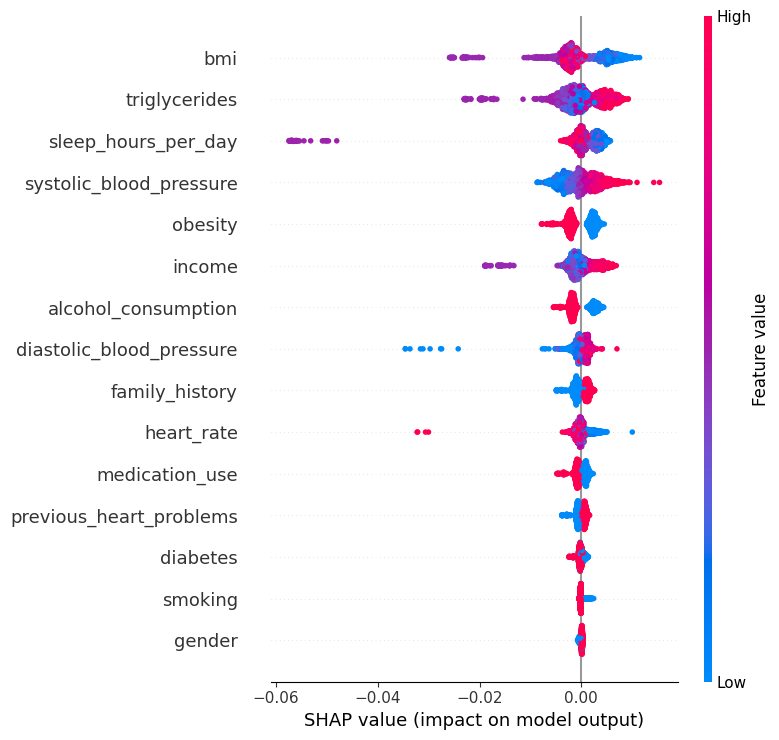

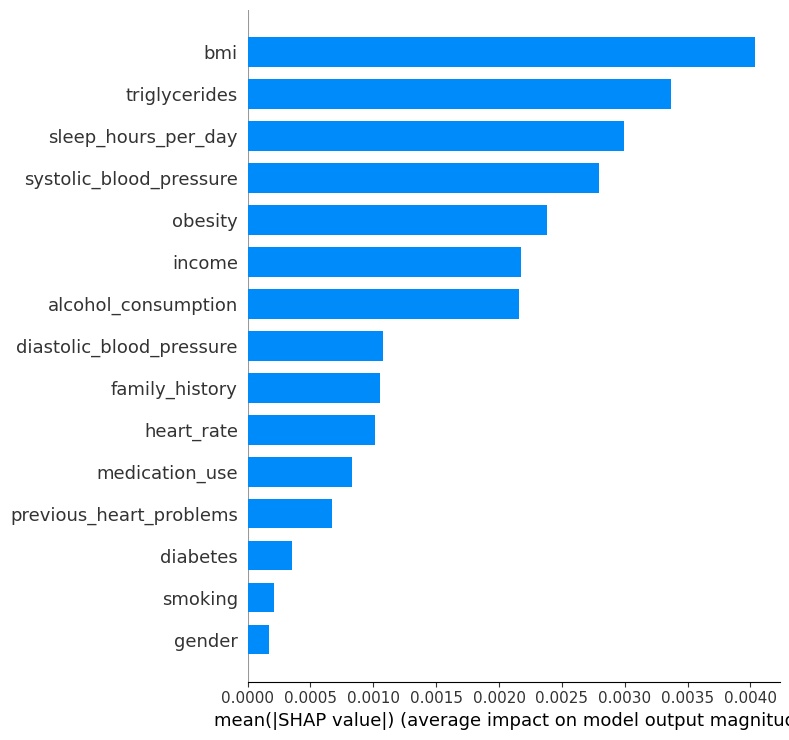

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

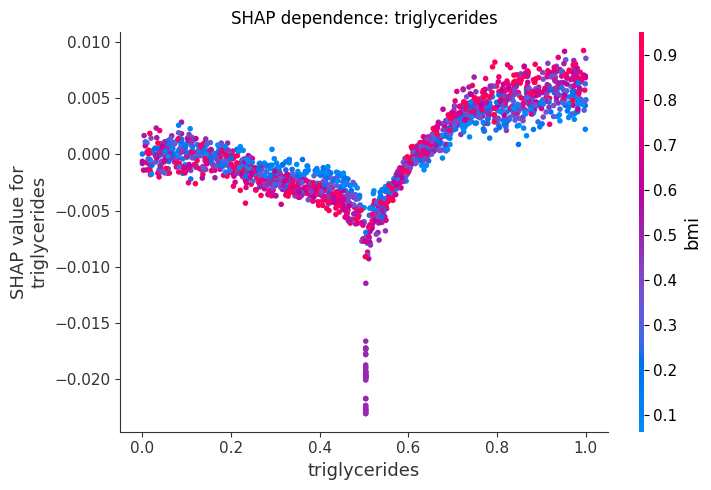

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

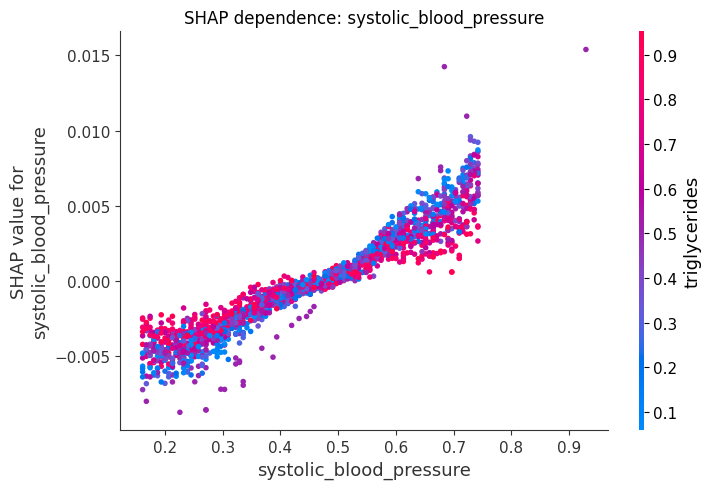

<Figure size 700x400 with 0 Axes>

In [13]:
# >>> 1) –£–∫–∞–∂–∏ —Å–≤–æ—é —É–∂–µ –æ–±—É—á–µ–Ω–Ω—É—é –º–æ–¥–µ–ª—å-–ø–∞–π–ø–ª–∞–π–Ω:
best_pipe = pipe_cat_reg  # ‚Üê –∑–¥–µ—Å—å —Ç–≤–æ–π –æ–±—É—á–µ–Ω–Ω—ã–π Pipeline

# >>> 2) –î–∞–π –µ–º—É –¥–∞–Ω–Ω—ã–µ –≤ —Ç–æ–º –∂–µ ¬´—Å—ã—Ä—ã–º¬ª –≤–∏–¥–µ, –∫–∞–∫ –ø—Ä–∏ fit (–¥–æ –ø—Ä–µ–ø—Ä–æ—Ü–µ—Å—Å–æ—Ä–∞):
X_raw_val = X_val.copy()   # –≤–∞–ª–∏–¥–∞—Ü–∏—è (–∏–ª–∏ X_tr / –ª—é–±–æ–π —Ñ—Ä–µ–π–º)

# ---- –≤—Å–ø–æ–º–æ–≥–∞—Ç–µ–ª—å–Ω–∞—è —Ñ—É–Ω–∫—Ü–∏—è: –ø—Ä–æ–≥–Ω–∞—Ç—å –¥–∞–Ω–Ω—ã–µ –¥–æ —à–∞–≥–∞ select –∏ –≤–µ—Ä–Ω—É—Ç—å –∏–º–µ–Ω–∞
def transform_up_to_select(pipeline, Xdf: pd.DataFrame):
    # 1) –ø—Ä–µ–ø—Ä–æ—Ü–µ—Å—Å–∏–Ω–≥
    X_prep = pipeline.named_steps["prep"].transform(Xdf)
    feat_names_prep = pipeline.named_steps["prep"].get_feature_names_out()

    # 2) —Å–µ–ª–µ–∫—Ç–æ—Ä (–º–æ–∂–µ—Ç –æ—Ç—Å—É—Ç—Å—Ç–≤–æ–≤–∞—Ç—å)
    if "select" in pipeline.named_steps:
        selector = pipeline.named_steps["select"]
        mask = selector.get_support()
        feat_names_sel = np.array(feat_names_prep)[mask]
        X_sel = selector.transform(X_prep)
    else:
        feat_names_sel = np.array(feat_names_prep)
        X_sel = X_prep

    # –Ω–∞ –≤—Å—è–∫–∏–π —Å–ª—É—á–∞–π –∫–æ–Ω–≤–µ—Ä—Ç –∏–∑ sparse
    if hasattr(X_sel, "toarray"):
        X_sel = X_sel.toarray()

    return X_sel, feat_names_sel

# –ø–æ–ª—É—á–∞–µ–º –º–∞—Ç—Ä–∏—Ü—É –∏ –∏–º–µ–Ω–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ—Å–ª–µ select
X_val_sel, feat_names_sel = transform_up_to_select(best_pipe, X_raw_val)

# ---- 3) –≠–∫—Å–ø–ª–µ–π–Ω–µ—Ä –ø–æ–¥ –¥–µ—Ä–µ–≤–æ (RF/CatBoost/XGB/LGBM)
model = best_pipe.named_steps["clf"]
explainer = shap.TreeExplainer(model)

# –¥–ª—è —Å—Ç–∞–±–∏–ª—å–Ω–æ—Å—Ç–∏ –º–æ–∂–Ω–æ –æ–≥—Ä–∞–Ω–∏—á–∏—Ç—å background/–∫-–≤–æ –ø—Ä–∏–º–µ—Ä–æ–≤
shap_values = explainer.shap_values(X_val_sel)

# CatBoost –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç —Å–ø–∏—Å–æ–∫ –ø–æ –∫–ª–∞—Å—Å–∞–º; –±–µ—Ä—ë–º –∫–ª–∞—Å—Å "1"
if isinstance(shap_values, list):
    # –≤—ã–±–∏—Ä–∞–µ–º –≤–∫–ª–∞–¥ –¥–ª—è –ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω–æ–≥–æ –∫–ª–∞—Å—Å–∞
    shap_vals_pos = shap_values[1] if len(shap_values) > 1 else shap_values[0]
else:
    shap_vals_pos = shap_values

# ---- 4) –ö—Ä–∞—Å–∏–≤—ã–µ –≥—Ä–∞—Ñ–∏–∫–∏ —Å —Ä–µ–∞–ª—å–Ω—ã–º–∏ –∏–º–µ–Ω–∞–º–∏ ----------------------------
# (A) summary_plot (beeswarm)
plt.figure(figsize=(9,10))
shap.summary_plot(shap_vals_pos, X_val_sel, feature_names=feat_names_sel, show=False)
plt.tight_layout()
plt.show()

# (B) summary bar (—Å—Ä–µ–¥–Ω–∏–µ |SHAP|)
plt.figure(figsize=(8,9))
shap.summary_plot(shap_vals_pos, X_val_sel, feature_names=feat_names_sel, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

# (C) –ø—Ä–∏–º–µ—Ä –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–µ–π –¥–ª—è –ø–∞—Ä—ã –≤–∞–∂–Ω—ã—Ö —Ñ–∏—á (–∑–∞–º–µ–Ω–∏ –Ω–∞ —Å–≤–æ–∏ –∏–º–µ–Ω–∞)
top_k = 5
top_idx = np.argsort(np.abs(shap_vals_pos).mean(axis=0))[::-1][:top_k]
for i in top_idx:
    fname = feat_names_sel[i]
    plt.figure(figsize=(7,4))
    shap.dependence_plot(
        ind=i, shap_values=shap_vals_pos, features=X_val_sel,
        feature_names=feat_names_sel, show=False
    )
    plt.title(f"SHAP dependence: {fname}")
    plt.tight_layout()
    plt.show()

In [14]:
heart_train['diet'].value_counts()

KeyError: 'diet'

In [15]:
# ---- 1) –§—É–Ω–∫—Ü–∏—è: –ø—Ä–æ–≥–Ω–∞—Ç—å X —á–µ—Ä–µ–∑ pipe –¥–æ —à–∞–≥–∞ SelectKBest –∏ –∑–∞–±—Ä–∞—Ç—å –∏–º–µ–Ω–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
def transform_until_select(pipe, X_df):
    # 1) –ø—Ä–µ–ø—Ä–æ—Ü–µ—Å—Å–æ—Ä
    X_prep = pipe.named_steps["prep"].transform(X_df)
    feat_names = pipe.named_steps["prep"].get_feature_names_out()
    # 2) selectKBest
    sel = pipe.named_steps["select"]
    X_sel = sel.transform(X_prep)
    mask = sel.get_support()
    feat_names_sel = np.array(feat_names)[mask]
    return X_sel, feat_names_sel

# ---- 2) –ø–æ–ª—É—á–∞–µ–º –≤–∞–ª–∏–¥–Ω—É—é –º–∞—Ç—Ä–∏—Ü—É –∏ –∏–º–µ–Ω–∞
X_val_sel, feat_names_sel = transform_until_select(pipe_cat, X_val)

# ---- 3) SHAP –¥–ª—è –º–æ–¥–µ–ª–∏ –≤–Ω—É—Ç—Ä–∏ –ø–∞–π–ø–ª–∞–π–Ω–∞
model = pipe_cat.named_steps["clf"]

import shap
explainer = shap.TreeExplainer(model)
# –î–ª—è –±–∏–Ω–∞—Ä–Ω–æ–π –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ TreeExplainer –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç —Å–ø–∏—Å–æ–∫ –∏–∑ 2 –º–∞—Å—Å–∏–≤–æ–≤; –±–µ—Ä—ë–º –∫–ª–∞—Å—Å 1
sv = explainer.shap_values(X_val_sel)
shap_values = sv[1] if isinstance(sv, list) else sv

# ---- 4) Summary plot –∏ dependence –ø–æ 'diet'
shap.summary_plot(shap_values, features=X_val_sel, feature_names=feat_names_sel, show=True)

if "diet" in feat_names_sel:
    shap.dependence_plot(
        "diet", shap_values, X_val_sel,
        feature_names=feat_names_sel, show=True
    )
else:
    # –µ—Å–ª–∏ 'diet' –Ω–µ –ø—Ä–æ—à—ë–ª SelectKBest ‚Äî —Å–æ–æ–±—â–∏–º –∫–∞–∫–∞—è –∏–º–µ–Ω–Ω–æ –æ—à–∏–±–∫–∞
    print("–í–Ω–∏–º–∞–Ω–∏–µ: 'diet' –Ω–µ –≤—Ö–æ–¥–∏—Ç –≤ –æ—Ç–æ–±—Ä–∞–Ω–Ω—ã–µ SelectKBest –ø—Ä–∏–∑–Ω–∞–∫–∏.")

NameError: name 'pipe_cat' is not defined

In [28]:
pd.crosstab(heart_train['diet'], y, normalize='index')

heart_attack_risk_binary         0         1
diet                                        
0                         0.651455  0.348545
1                         0.630458  0.369542
2                         0.647711  0.352289
3                         1.000000  0.000000

–ß—Ç–æ —ç—Ç–æ –∑–Ω–∞—á–∏—Ç

–î–ª—è –∫–∞—Ç–µ–≥–æ—Ä–∏–π 0, 1, 2 —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ç–∞—Ä–≥–µ—Ç–∞ ~ 65% / 35% ‚Äî –≤–ø–æ–ª–Ω–µ –ø–æ—Ö–æ–∂–µ –Ω–∞ –æ–±—â—É—é –≤—ã–±–æ—Ä–∫—É.

–î–ª—è –∫–∞—Ç–µ–≥–æ—Ä–∏–∏ diet=3 —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ 100% –∫–ª–∞—Å—Å 0, 0% –∫–ª–∞—Å—Å 1.

–≠—Ç–æ –∑–Ω–∞—á–∏—Ç, —á—Ç–æ –Ω–∞–ª–∏—á–∏–µ diet=3 –ø–æ–ª–Ω–æ—Å—Ç—å—é –ø—Ä–µ–¥—Å–∫–∞–∑—ã–≤–∞–µ—Ç –æ—Ç—Å—É—Ç—Å—Ç–≤–∏–µ —Å–µ—Ä–¥–µ—á–Ω–æ–≥–æ –ø—Ä–∏—Å—Ç—É–ø–∞ ‚Üí –ø—Ä–∏–∑–Ω–∞–∫ —Å—Ç–∞–ª –∏–¥–µ–∞–ª—å–Ω—ã–º –ø—Ä–µ–¥–∏–∫—Ç–æ—Ä–æ–º.

–¢–∞–∫–æ–µ –≤ —Ä–µ–∞–ª—å–Ω–æ–π –∂–∏–∑–Ω–∏ –ø–æ—á—Ç–∏ –Ω–µ –≤—Å—Ç—Ä–µ—á–∞–µ—Ç—Å—è (—Å–ª–∏—à–∫–æ–º —á–∏—Å—Ç–æ–µ —Ä–∞–∑–¥–µ–ª–µ–Ω–∏–µ), –∞ –∑–Ω–∞—á–∏—Ç:

–õ–∏–±–æ –≤ –≤—ã–±–æ—Ä–∫–µ –º–∞–ª–æ –Ω–∞–±–ª—é–¥–µ–Ω–∏–π (—É —Ç–µ–±—è –≤—Å–µ–≥–æ 243), –∏ —Å–ª—É—á–∞–π–Ω–æ –ø–æ–ø–∞–ª–æ—Å—å, —á—Ç–æ –≤—Å–µ –æ–Ω–∏ –±–µ–∑ –∏–Ω—Ñ–∞—Ä–∫—Ç–∞.

–õ–∏–±–æ diet=3 —Å–≤—è–∑–∞–Ω–æ —Å —Å–∞–º–∏–º –ø—Ä–æ—Ü–µ—Å—Å–æ–º —Å–±–æ—Ä–∞ –¥–∞–Ω–Ω—ã—Ö ‚Üí –Ω–∞–ø—Ä–∏–º–µ—Ä, —ç—Ç–∞ –∫–∞—Ç–µ–≥–æ—Ä–∏—è –≤—Å—Ç—Ä–µ—á–∞–µ—Ç—Å—è —Ç–æ–ª—å–∫–æ —É –ø–∞—Ü–∏–µ–Ω—Ç–æ–≤ –∏–∑ –æ–ø—Ä–µ–¥–µ–ª—ë–Ω–Ω–æ–≥–æ –∏—Å—Ç–æ—á–Ω–∏–∫–∞ (–≥–¥–µ –Ω–µ—Ç –±–æ–ª—å–Ω—ã—Ö).

–õ–∏–±–æ —ç—Ç–æ —Ä–µ–∑—É–ª—å—Ç–∞—Ç –æ–±—Ä–∞–±–æ—Ç–∫–∏ (–∏–º–ø—É—Ç–∞—Ü–∏–∏ / –∫–æ–¥–∏—Ä–æ–≤–∞–Ω–∏—è), –≥–¥–µ diet=3 –≤—ã—Å—Ç–∞–≤–ª—è–µ—Ç—Å—è —Ç–æ–ª—å–∫–æ –µ—Å–ª–∏ —Ç–∞—Ä–≥–µ—Ç=0, —á—Ç–æ –∏ –µ—Å—Ç—å —É—Ç–µ—á–∫–∞ –¥–∞–Ω–Ω—ã—Ö.

In [29]:
# –±–µ—Ä—ë–º —Ç–æ–ª—å–∫–æ —Å—Ç–æ–ª–±–µ—Ü diet
tmp = heart_train[["diet"]].copy()
print("NaN in diet before:", tmp["diet"].isna().sum())

gmi = GroupMedianImputer().fit(tmp)   # —Ç–≤–æ–π –∫–∞—Å—Ç–æ–º–Ω—ã–π –∏–º–ø–∞–π—Ç–µ—Ä
print("Median that GMI learned for diet:", gmi.medians_["diet"])

diet_imp = gmi.transform(tmp)[:, 0]
print("NaN after:", np.isnan(diet_imp).sum())
print("Unique values after GMI:", np.unique(diet_imp, return_counts=True))

NaN in diet before: 0
Median that GMI learned for diet: 1.0
NaN after: 0
Unique values after GMI: (array([0, 1, 2, 3], dtype=int64), array([2783, 2863, 2796,  243], dtype=int64))


In [30]:
# –ø—Ä–æ–≥–æ–Ω—è–µ–º —á–µ—Ä–µ–∑ —Ç–≤–æ–π ColumnTransformer –¥–ª—è —Ç–µ–∫—É—â–µ–≥–æ –ø—Ä–æ–µ–∫—Ç–∞
Xp = preprocessor.fit_transform(heart_train.drop(columns=[TARGET_COL]))
fn = preprocessor.get_feature_names_out()
diet_idx = list(fn).index("diet")  # –≥–¥–µ –ª–µ–∂–∏—Ç diet –≤ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–Ω–æ–π –º–∞—Ç—Ä–∏—Ü–µ

diet_after = np.asarray(Xp)[:, diet_idx]
print("Diet after preprocessor - unique values:", np.unique(diet_after, return_counts=True))

# —Å–≤–µ—Ä–∏–º —Å —Ç–∞—Ä–≥–µ—Ç–æ–º —É–∂–µ –ü–û–°–õ–ï –ø—Ä–µ–ø—Ä–æ—Ü–µ—Å—Å–æ—Ä–∞
print(pd.crosstab(pd.Series(diet_after, name="diet_after"),
                  heart_train[TARGET_COL], normalize="index"))

Diet after preprocessor - unique values: (array([0., 1., 2., 3.]), array([2783, 2863, 2796,  243], dtype=int64))
heart_attack_risk_binary       0.0       1.0
diet_after                                  
0.0                       0.637306  0.362694
1.0                       0.661122  0.338878
2.0                       0.639266  0.360734
3.0                       0.674419  0.325581


In [31]:
ix_d3 = heart_train.index[heart_train["diet"] == 3]
print("rows with diet=3:", len(ix_d3))
print("target distribution for diet=3:\n", heart_train.loc[ix_d3, TARGET_COL].value_counts())

# –ø–æ—Å–º–æ—Ç—Ä–∏ –∏—Ö –ø—Ä–æ—Ñ–∞–π–ª ‚Äî –Ω–µ—Ç –ª–∏ –æ–±—â–∏—Ö –æ—Å–æ–±–µ–Ω–Ω–æ—Å—Ç–µ–π
cols_peek = ["age","bmi","cholesterol","triglycerides",
             "systolic_blood_pressure","diastolic_blood_pressure",
             "exercise_hours_per_week","physical_activity_days_per_week",
             "sedentary_hours_per_day"]
display(heart_train.loc[ix_d3, cols_peek].describe())

rows with diet=3: 243
target distribution for diet=3:
 heart_attack_risk_binary
0.0    243
Name: count, dtype: int64


age           bmi  cholesterol  triglycerides  \
count  243.000000  2.430000e+02    243.00000   2.430000e+02   
mean     0.482961  4.947741e-01      0.49978   5.036030e-01   
std      0.161522  1.112515e-16      0.00000   2.225029e-16   
min      0.000000  4.947741e-01      0.49978   5.036030e-01   
25%      0.370787  4.947741e-01      0.49978   5.036030e-01   
50%      0.516854  4.947741e-01      0.49978   5.036030e-01   
75%      0.578652  4.947741e-01      0.49978   5.036030e-01   
max      1.000000  4.947741e-01      0.49978   5.036030e-01   

       systolic_blood_pressure  diastolic_blood_pressure  \
count               243.000000                243.000000   
mean                  0.392646                  0.357355   
std                   0.160063                  0.165995   
min                   0.000000                  0.000000   
25%                   0.283871                  0.232558   
50%                   0.354839                  0.360465   
75%                   0.480645                  0.453488   
max                   1.000000                  1.000000   

       exercise_hours_per_week  physical_activity_days_per_week  \
count                243.00000                              0.0   
mean                   0.50211                              NaN   
std                    0.00000                              NaN   
min                    0.50211                              NaN   
25%                    0.50211                              NaN   
50%                    0.50211                              NaN   
75%                    0.50211                              NaN   
max                    0.50211                              NaN   

       sedentary_hours_per_day  
count             2.430000e+02  
mean              4.999199e-01  
std               5.562573e-17  
min               4.999199e-01  
25%               4.999199e-01  
50%               4.999199e-01  
75%               4.999199e-01  
max               4.999199e-01

–°—É–¥—è –ø–æ —Ç–≤–æ–∏–º –ª–æ–≥–∞–º, —Å diet=3 —Å–∏—Ç—É–∞—Ü–∏—è —Å–ª–µ–¥—É—é—â–∞—è:

–í –∏—Å—Ö–æ–¥–Ω–æ–º –¥–∞—Ç–∞—Å–µ—Ç–µ diet=3 –¥–µ–π—Å—Ç–≤–∏—Ç–µ–ª—å–Ω–æ –≤—Å—Ç—Ä–µ—á–∞–µ—Ç—Å—è (243 —Å—Ç—Ä–æ–∫–∏).

–¶–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è (heart_attack_risk_binary) –¥–ª—è —ç—Ç–∏—Ö —Å—Ç—Ä–æ–∫ –≤—Å–µ–≥–¥–∞ —Ä–∞–≤–Ω–∞ 0 ‚Üí —ç—Ç–æ ¬´–∏–¥–µ–∞–ª—å–Ω—ã–π –ø—Ä–µ–¥—Å–∫–∞–∑–∞—Ç–µ–ª—å¬ª –±–µ–∑ –≤–∞—Ä–∏–∞—Ü–∏–∏.

–ü–æ—Å–ª–µ –ø—Ä–æ—Ö–æ–∂–¥–µ–Ω–∏—è —á–µ—Ä–µ–∑ —Ç–≤–æ–π GroupMedianImputer –∏ –ø—Ä–µ–ø—Ä–æ—Ü–µ—Å—Å–æ—Ä –∑–Ω–∞—á–µ–Ω–∏–µ —Å–æ—Ö—Ä–∞–Ω–∏–ª–æ—Å—å (0,1,2,3 –æ—Å—Ç–∞–ª–∏—Å—å).

–ù–æ –≤—Å–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ —É diet=3 –∑–∞—Ñ–∏–∫—Å–∏—Ä–æ–≤–∞–Ω—ã –Ω–∞ –æ–¥–∏–Ω–∞–∫–æ–≤—ã—Ö —É—Ä–æ–≤–Ω—è—Ö (–∏–ª–∏ –ø–æ—á—Ç–∏ –±–µ–∑ –¥–∏—Å–ø–µ—Ä—Å–∏–∏). –ù–∞–ø—Ä–∏–º–µ—Ä:

cholesterol, triglycerides, exercise_hours_per_week ‚Üí –∫–æ–Ω—Å—Ç–∞–Ω—Ç—ã, –±–µ–∑ —Ä–∞–∑–±—Ä–æ—Å–∞.

physical_activity_days_per_week –æ–∫–∞–∑–∞–ª—Å—è NaN —É –≤—Å–µ—Ö.

–≠—Ç–æ –∫–ª—é—á–µ–≤–æ–π —Å–∏–º–ø—Ç–æ–º —É—Ç–µ—á–∫–∏ –¥–∞–Ω–Ω—ã—Ö –∏–ª–∏ –æ—à–∏–±–∫–∏ –ø–æ–¥–≥–æ—Ç–æ–≤–∫–∏.

–ü–æ—á–µ–º—É —ç—Ç–æ –ø—Ä–æ–±–ª–µ–º–∞

–ü–æ–ª–Ω—ã–π —Ç–∞—Ä–≥–µ—Ç-–∫–æ–ª–ª–∞–ø—Å: –≤—Å–µ –Ω–∞–±–ª—é–¥–µ–Ω–∏—è —Å diet=3 ‚Üí –∫–ª–∞—Å—Å 0. –≠—Ç–æ –ø—Ä–µ–≤—Ä–∞—â–∞–µ—Ç –∫–∞—Ç–µ–≥–æ—Ä–∏—é –≤ –º–∞—Ä–∫–µ—Ä —Ç–∞—Ä–≥–µ—Ç–∞, –∏ –º–æ–¥–µ–ª—å –±—É–¥–µ—Ç ¬´–æ–±—É—á–∞—Ç—å—Å—è –Ω–∞ —è—Ä–ª—ã–∫–µ¬ª.

–ù–µ—Ç –¥–∏—Å–ø–µ—Ä—Å–∏–∏ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤: –µ—Å–ª–∏ –ø—Ä–∏–∑–Ω–∞–∫–∏ –≤–Ω—É—Ç—Ä–∏ –≥—Ä—É–ø–ø—ã —Å—Ç–∞–ª–∏ –∫–æ–Ω—Å—Ç–∞–Ω—Ç–æ–π (–Ω–∞–ø—Ä–∏–º–µ—Ä, –∏–∑-–∑–∞ –∞–≥—Ä–µ—Å—Å–∏–≤–Ω–æ–≥–æ –Ω–æ—Ä–º–∏—Ä–æ–≤–∞–Ω–∏—è, –≥—Ä—É–ø–ø–æ–≤–æ–π –∞–≥—Ä–µ–≥–∞—Ü–∏–∏ –∏–ª–∏ –±–∞–≥–æ–≤ –∏–º–ø—É—Ç–∞—Ü–∏–∏), —Ç–æ —ç—Ç–∞ –≥—Ä—É–ø–ø–∞ –ø–µ—Ä–µ—Å—Ç–∞—ë—Ç –±—ã—Ç—å –≤–∞–ª–∏–¥–Ω–æ–π –¥–ª—è –æ–±—É—á–µ–Ω–∏—è.

–†–µ–∞–ª—å–Ω—ã–π –¥–∞—Ç–∞—Å–µ—Ç –∏–ª–∏ –æ—à–∏–±–∫–∞?

–ï—Å–ª–∏ –¥–∞–Ω–Ω—ã–µ —Ä–µ–∞–ª—å–Ω–æ —Ç–∞–∫–∏–µ (–Ω–∞–ø—Ä–∏–º–µ—Ä, –≤—Å–µ –ª—é–¥–∏ —Å diet=3 –Ω–µ –∏–º–µ–ª–∏ –∏–Ω—Ñ–∞—Ä–∫—Ç–æ–≤), —Ç–æ —ç—Ç–æ —Å–º–µ—â—ë–Ω–Ω–∞—è –≤—ã–±–æ—Ä–∫–∞, –∏ –º–æ–¥–µ–ª—å –ø—Ä–æ—Å—Ç–æ –æ—Ç—Ä–∞–∂–∞–µ—Ç –∞—Ä—Ç–µ—Ñ–∞–∫—Ç.

–ï—Å–ª–∏ —ç—Ç–æ –∞—Ä—Ç–µ—Ñ–∞–∫—Ç –ø—Ä–µ–ø—Ä–æ—Ü–µ—Å—Å–∏–Ω–≥–∞, —Ç–æ —ç—Ç–æ —É—Ç–µ—á–∫–∞ –¥–∞–Ω–Ω—ã—Ö: –≥–¥–µ-—Ç–æ —à–∞–≥ –æ–±—Ä–∞–±–æ—Ç–∫–∏ ¬´–ø–æ–¥–º–µ–Ω–∏–ª¬ª –∑–Ω–∞—á–µ–Ω–∏—è.

In [32]:
# –ø—Ä–æ–≤–µ—Ä—è–µ–º —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ diet –≤ train/test
print("Train:")
print(X_tr["diet"].value_counts(normalize=True))

print("\nTest:")
print(X_val["diet"].value_counts(normalize=True))

Train:
diet
1    0.327001
2    0.321963
0    0.321387
3    0.029649
Name: proportion, dtype: float64

Test:
diet
1    0.340242
2    0.321819
0    0.316638
3    0.021301
Name: proportion, dtype: float64
